In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

C:\Users\ssahi\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\ssahi\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
C:\Users\ssahi\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


### Initial state

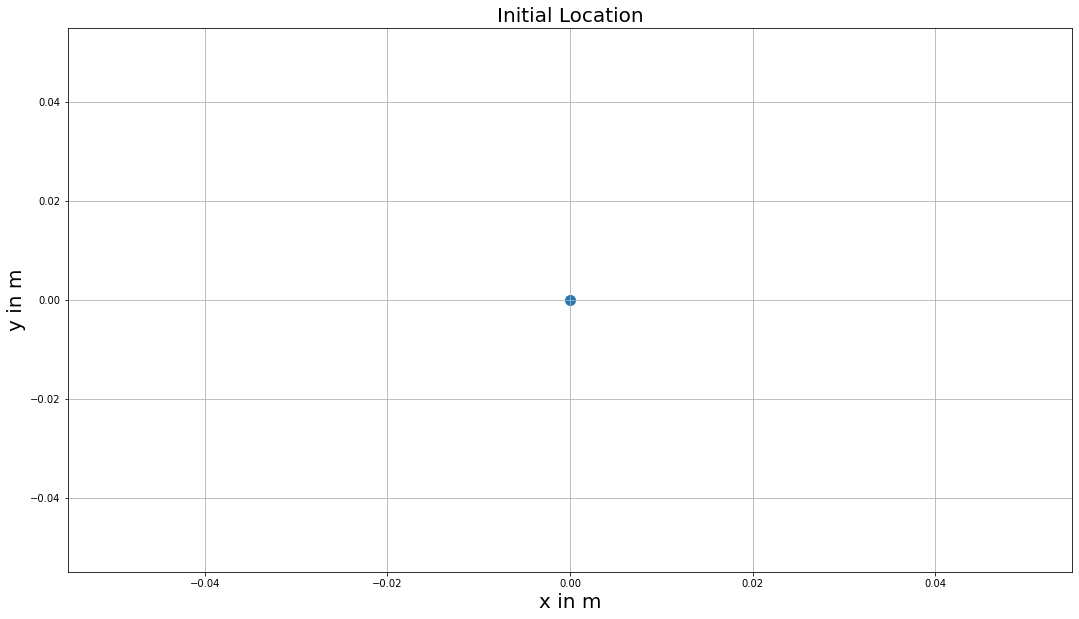

In [2]:
plt.figure(figsize=(18, 10))
x = np.matrix([[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]).T
n = x.size  # States
plt.scatter(float(x[0]), float(x[1]), s=100)
plt.title("Initial Location", fontsize=20)
plt.ylabel("y in m", fontsize=20)
plt.xlabel("x in m", fontsize=20)
plt.grid(True)

### Initial Uncertainty

[[10.  0.  0.  0.  0.  0.]
 [ 0. 10.  0.  0.  0.  0.]
 [ 0.  0. 10.  0.  0.  0.]
 [ 0.  0.  0. 10.  0.  0.]
 [ 0.  0.  0.  0. 10.  0.]
 [ 0.  0.  0.  0.  0. 10.]]


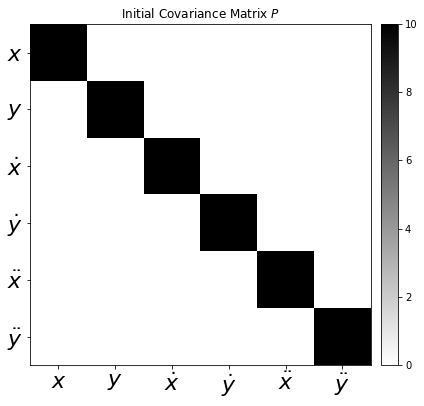

In [3]:
P = np.matrix(
    [
        [10.0, 0.0, 0.0, 0.0, 0.0, 0.0],
        [0.0, 10.0, 0.0, 0.0, 0.0, 0.0],
        [0.0, 0.0, 10.0, 0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, 10.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, 0.0, 10.0, 0.0],
        [0.0, 0.0, 0.0, 0.0, 0.0, 10.0],
    ]
)
print(P)

fig = plt.figure(figsize=(6, 6))
im = plt.imshow(P, interpolation="none", cmap=plt.get_cmap("binary"))
plt.title("Initial Covariance Matrix $P$")
ylocs, ylabels = plt.yticks()
# set the locations of the yticks
plt.yticks(np.arange(7))
# set the locations and labels of the yticks
plt.yticks(
    np.arange(6),
    ("$x$", "$y$", "$\dot x$", "$\dot y$", "$\ddot x$", "$\ddot y$"),
    fontsize=22,
)

xlocs, xlabels = plt.xticks()
# set the locations of the yticks
plt.xticks(np.arange(7))
# set the locations and labels of the yticks
plt.xticks(
    np.arange(6),
    ("$x$", "$y$", "$\dot x$", "$\dot y$", "$\ddot x$", "$\ddot y$"),
    fontsize=22,
)

plt.xlim([-0.5, 5.5])
plt.ylim([5.5, -0.5])

from mpl_toolkits.axes_grid1 import make_axes_locatable

divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "5%", pad="3%")
plt.colorbar(im, cax=cax)

plt.tight_layout()

### Dynamic matrix

In [4]:
dt = 0.1  # Time Step between Filter Steps

A = np.matrix(
    [
        [1.0, 0.0, dt, 0.0, 1 / 2.0 * dt ** 2, 0.0],
        [0.0, 1.0, 0.0, dt, 0.0, 1 / 2.0 * dt ** 2],
        [0.0, 0.0, 1.0, 0.0, dt, 0.0],
        [0.0, 0.0, 0.0, 1.0, 0.0, dt],
        [0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
        [0.0, 0.0, 0.0, 0.0, 0.0, 1.0],
    ]
)
print(A)

[[1.    0.    0.1   0.    0.005 0.   ]
 [0.    1.    0.    0.1   0.    0.005]
 [0.    0.    1.    0.    0.1   0.   ]
 [0.    0.    0.    1.    0.    0.1  ]
 [0.    0.    0.    0.    1.    0.   ]
 [0.    0.    0.    0.    0.    1.   ]]


### Measurement Matrix

In [5]:
# In this example the position and acceleration are measured
H = np.matrix(
    [
        [0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
        [0.0, 0.0, 0.0, 0.0, 0.0, 1.0],
        [1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
        [0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
    ]
)
print(H)

[[0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]]


### Measurement noise Covariance

In [6]:
ra = 10.0 ** 2
rp = 2.0 ** 2

R = np.matrix(
    [[ra, 0.0, 0.0, 0.0], [0.0, ra, 0.0, 0.0], [0.0, 0.0, rp, 0.0], [0.0, 0.0, 0.0, rp]]
)
print(R)

[[100.   0.   0.   0.]
 [  0. 100.   0.   0.]
 [  0.   0.   4.   0.]
 [  0.   0.   0.   4.]]


### Process noise Covariance Matrix

In [7]:
from sympy import Symbol, Matrix
from sympy.interactive import printing

dts = Symbol("\Delta t")

## The Position of an object can be influenced by a force (e.g. wind), which leads to an acceleration disturbance (noise). 
## This process noise has to be modeled with the process noise covariance matrix Q.

In [8]:
sj = 0.1

# Certain distribution is considered here (any other distribution can also be considered)
Q = (
    np.matrix(
        [
            [(dt ** 6) / 36, 0, (dt ** 5) / 12, 0, (dt ** 4) / 6, 0],
            [0, (dt ** 6) / 36, 0, (dt ** 5) / 12, 0, (dt ** 4) / 6],
            [(dt ** 5) / 12, 0, (dt ** 4) / 4, 0, (dt ** 3) / 2, 0],
            [0, (dt ** 5) / 12, 0, (dt ** 4) / 4, 0, (dt ** 3) / 2],
            [(dt ** 4) / 6, 0, (dt ** 3) / 2, 0, (dt ** 2), 0],
            [0, (dt ** 4) / 6, 0, (dt ** 3) / 2, 0, (dt ** 2)],
        ]
    )
    * sj ** 2
)

print(Q)

[[2.77777778e-10 0.00000000e+00 8.33333333e-09 0.00000000e+00
  1.66666667e-07 0.00000000e+00]
 [0.00000000e+00 2.77777778e-10 0.00000000e+00 8.33333333e-09
  0.00000000e+00 1.66666667e-07]
 [8.33333333e-09 0.00000000e+00 2.50000000e-07 0.00000000e+00
  5.00000000e-06 0.00000000e+00]
 [0.00000000e+00 8.33333333e-09 0.00000000e+00 2.50000000e-07
  0.00000000e+00 5.00000000e-06]
 [1.66666667e-07 0.00000000e+00 5.00000000e-06 0.00000000e+00
  1.00000000e-04 0.00000000e+00]
 [0.00000000e+00 1.66666667e-07 0.00000000e+00 5.00000000e-06
  0.00000000e+00 1.00000000e-04]]


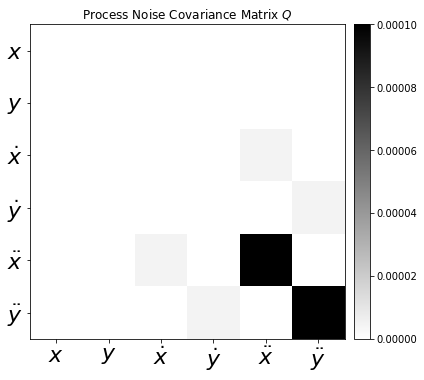

In [9]:
fig = plt.figure(figsize=(6, 6))
im = plt.imshow(Q, interpolation="none", cmap=plt.get_cmap("binary"))
plt.title("Process Noise Covariance Matrix $Q$")
ylocs, ylabels = plt.yticks()
# set the locations of the yticks
plt.yticks(np.arange(7))
# set the locations and labels of the yticks
plt.yticks(
    np.arange(6),
    ("$x$", "$y$", "$\dot x$", "$\dot y$", "$\ddot x$", "$\ddot y$"),
    fontsize=22,
)

xlocs, xlabels = plt.xticks()
# set the locations of the yticks
plt.xticks(np.arange(7))
# set the locations and labels of the yticks
plt.xticks(
    np.arange(6),
    ("$x$", "$y$", "$\dot x$", "$\dot y$", "$\ddot x$", "$\ddot y$"),
    fontsize=22,
)

plt.xlim([-0.5, 5.5])
plt.ylim([5.5, -0.5])

from mpl_toolkits.axes_grid1 import make_axes_locatable

divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "5%", pad="3%")
plt.colorbar(im, cax=cax)

plt.tight_layout()

In [10]:
I = np.eye(n)

### Measurement

In [12]:
import pandas as pd
from pyproj import Proj

# Read data

# Use every 5th value to get GPS updates in every timestep
n_rows = 10800  # len(df)
skip = np.arange(n_rows)
skip = np.delete(skip, np.arange(0, n_rows, 5))
df = pd.read_csv("2014-03-26-000-Data.csv", skiprows=skip)

# Extract values
ax = df["ax"].dropna()
ay = df["ay"].dropna()
px = df["latitude"].dropna()
py = df["longitude"].dropna()

m = len(df["ax"])  # Measurements

# Lat Lon to UTM
utm_converter = Proj(
    "+proj=utm +zone=33U, +south +ellps=WGS84 +datum=WGS84 +units=m +no_defs"
)

for i in range(len(px)):
    py[i], px[i] = utm_converter(py[i], px[i])
    px[i] = px[i] + np.random.normal(0, 2.0, 1)
    py[i] = py[i] + np.random.normal(0, 2.0, 1)
    # px[i] = 0 #TODO
    # py[i] = 0 #TODO

# Start from position (0 ,0)
py_offset = py[0]
px_offset = px[0]
px = px - px_offset
py = py - py_offset

# Stack measurement vector
measurements = np.vstack((ax, ay, px, py))

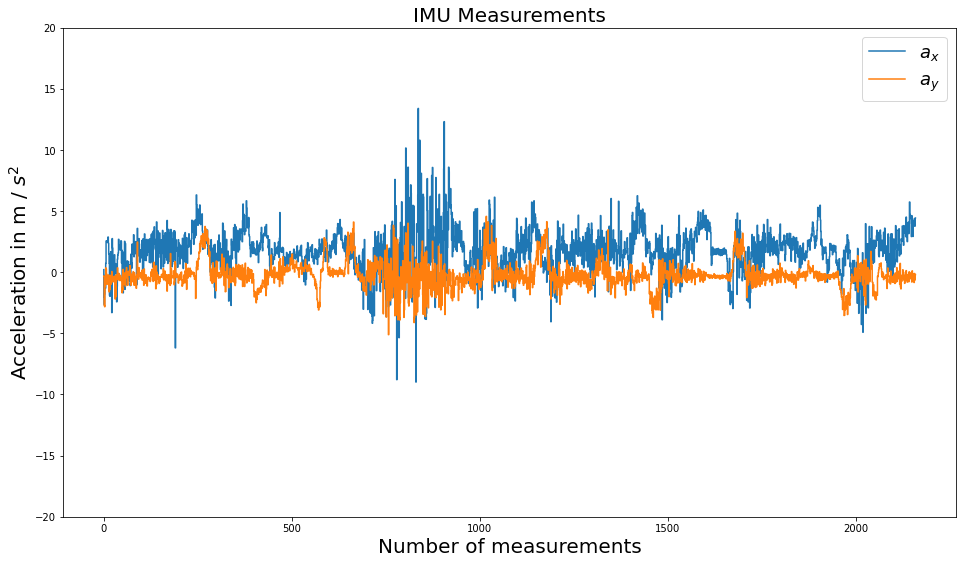

In [13]:
fig = plt.figure(figsize=(16, 9))
plt.step(range(m), ax, label="$a_x$")
plt.step(range(m), ay, label="$a_y$")
plt.ylabel("Acceleration in m / $s^2$", fontsize=20)
plt.xlabel("Number of measurements", fontsize=20)
plt.title("IMU Measurements", fontsize=20)
plt.ylim([-20, 20])
plt.legend(loc="best", prop={"size": 18})

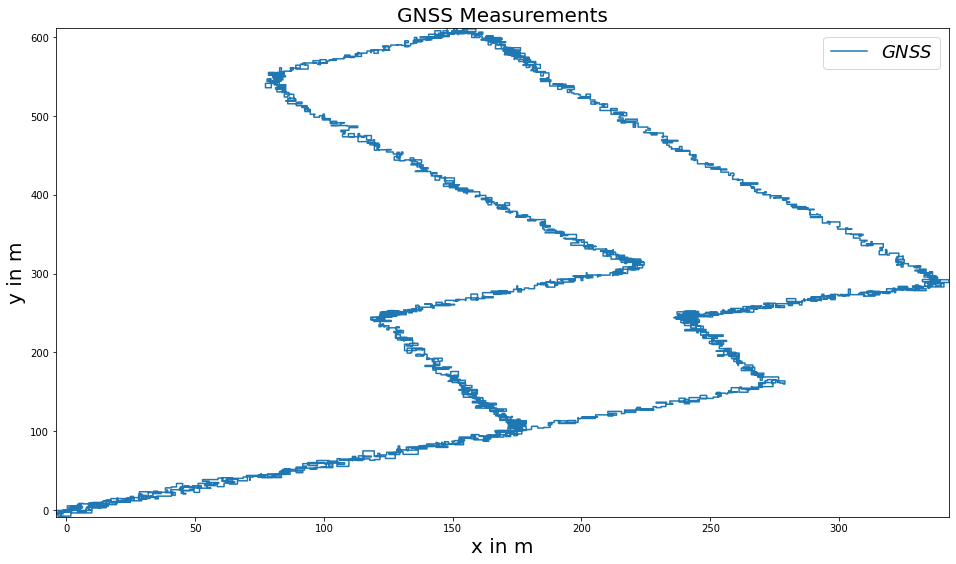

In [14]:
fig = plt.figure(figsize=(16, 9))
plt.step(px, py, label="$GNSS$")
plt.xlabel("x in m", fontsize=20)
plt.ylabel("y in m", fontsize=20)
plt.title("GNSS Measurements", fontsize=20)
plt.xlim([min(px), max(px)])
plt.ylim([min(py), max(py)])
plt.legend(loc="best", prop={"size": 18})

In [15]:
# Preallocation for Plotting
xt = []
yt = []
dxt = []
dyt = []
ddxt = []
ddyt = []
Zx = []
Zy = []
Px = []
Py = []
Pdx = []
Pdy = []
Pddx = []
Pddy = []
Kx = []
Ky = []
Kdx = []
Kdy = []
Kddx = []
Kddy = []

## Kalman Filter

In [16]:
for n in range(m):

    # Time Update (Prediction)
    # ========================
    # Project the state ahead
    x = A * x

    # Project the error covariance ahead
    P = A * P * A.T + Q

    # Measurement Update (Correction)
    # ===============================
    # Compute the Kalman Gain
    S = H * P * H.T + R
    K = (P * H.T) * np.linalg.pinv(S)

    # Update the estimate via z
    Z = measurements[:, n].reshape(H.shape[0], 1)
    y = Z - (H * x)  # Innovation or Residual
    x = x + (K * y)

    # Update the error covariance
    P = (I - (K * H)) * P

    # Save states for Plotting
    xt.append(float(x[0]))
    yt.append(float(x[1]))
    dxt.append(float(x[2]))
    dyt.append(float(x[3]))
    ddxt.append(float(x[4]))
    ddyt.append(float(x[5]))
    Zx.append(float(Z[0]))
    Zy.append(float(Z[1]))
    Px.append(float(P[0, 0]))
    Py.append(float(P[1, 1]))
    Pdx.append(float(P[2, 2]))
    Pdy.append(float(P[3, 3]))
    Pddx.append(float(P[4, 4]))
    Pddy.append(float(P[5, 5]))
    Kx.append(float(K[0, 0]))
    Ky.append(float(K[1, 0]))
    Kdx.append(float(K[2, 0]))
    Kdy.append(float(K[3, 0]))
    Kddx.append(float(K[4, 0]))
    Kddy.append(float(K[5, 0]))

## Plots

### Covariance Matrix

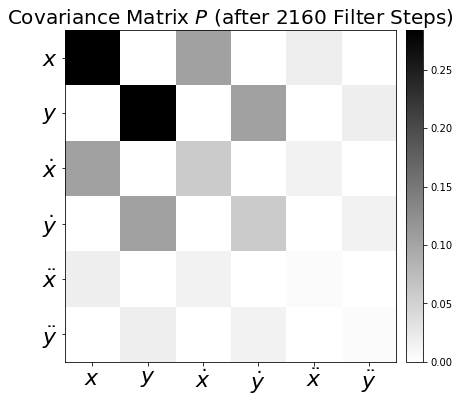

In [17]:
fig = plt.figure(figsize=(6, 6))
im = plt.imshow(P, interpolation="none", cmap=plt.get_cmap("binary"))
plt.title("Covariance Matrix $P$ (after %i Filter Steps)" % (m), fontsize=20)
ylocs, ylabels = plt.yticks()
# set the locations of the yticks
plt.yticks(np.arange(7))
# set the locations and labels of the yticks
plt.yticks(
    np.arange(6),
    ("$x$", "$y$", "$\dot x$", "$\dot y$", "$\ddot x$", "$\ddot y$"),
    fontsize=22,
)

xlocs, xlabels = plt.xticks()
# set the locations of the yticks
plt.xticks(np.arange(7))
# set the locations and labels of the yticks
plt.xticks(
    np.arange(6),
    ("$x$", "$y$", "$\dot x$", "$\dot y$", "$\ddot x$", "$\ddot y$"),
    fontsize=22,
)

plt.xlim([-0.5, 5.5])
plt.ylim([5.5, -0.5])

from mpl_toolkits.axes_grid1 import make_axes_locatable

divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "5%", pad="3%")
plt.colorbar(im, cax=cax)


plt.tight_layout()

### State vector

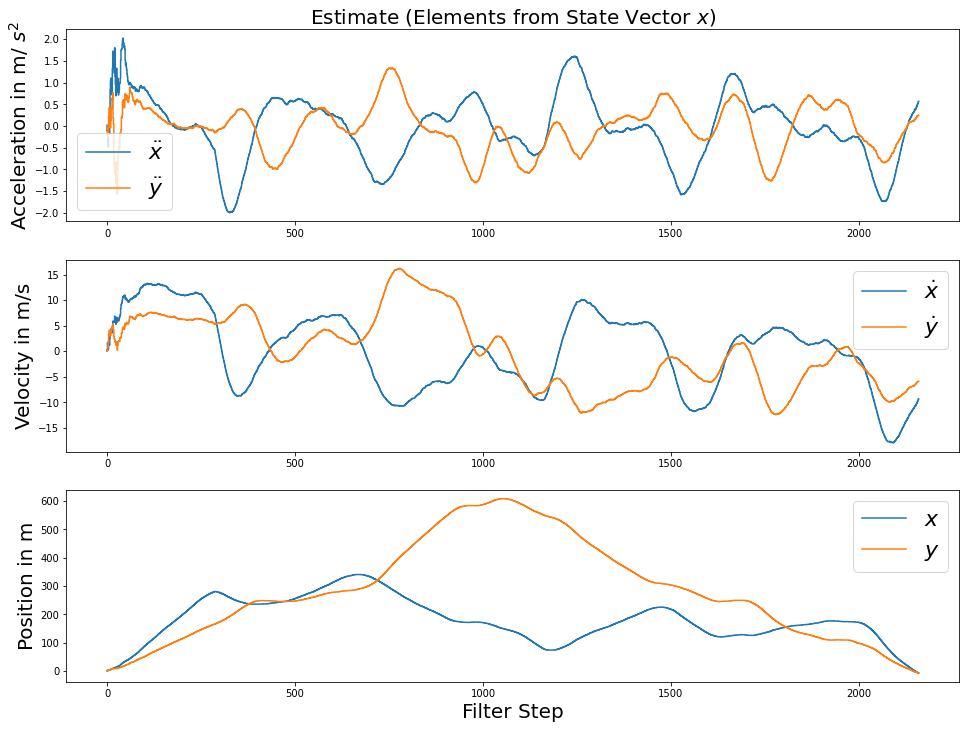

In [18]:
fig = plt.figure(figsize=(16, 12))

plt.subplot(311)
plt.step(range(len(measurements[0])), ddxt, label="$\ddot x$")
plt.step(range(len(measurements[0])), ddyt, label="$\ddot y$")

plt.title("Estimate (Elements from State Vector $x$)", fontsize=20)
plt.legend(loc="best", prop={"size": 22})
plt.ylabel("Acceleration in m/ $s^2$", fontsize=20)

plt.subplot(312)
plt.step(range(len(measurements[0])), dxt, label="$\dot x$")
plt.step(range(len(measurements[0])), dyt, label="$\dot y$")

plt.ylabel("")
plt.legend(loc="best", prop={"size": 22})
plt.ylabel("Velocity in m/s", fontsize=20)

plt.subplot(313)
plt.step(range(len(measurements[0])), xt, label="$x$")
plt.step(range(len(measurements[0])), yt, label="$y$")

plt.xlabel("Filter Step", fontsize=20)
plt.ylabel("Position in m", fontsize=20)
plt.legend(loc="best", prop={"size": 22})

### Position x/y

(-7.75210381822571, 609.023237646433)

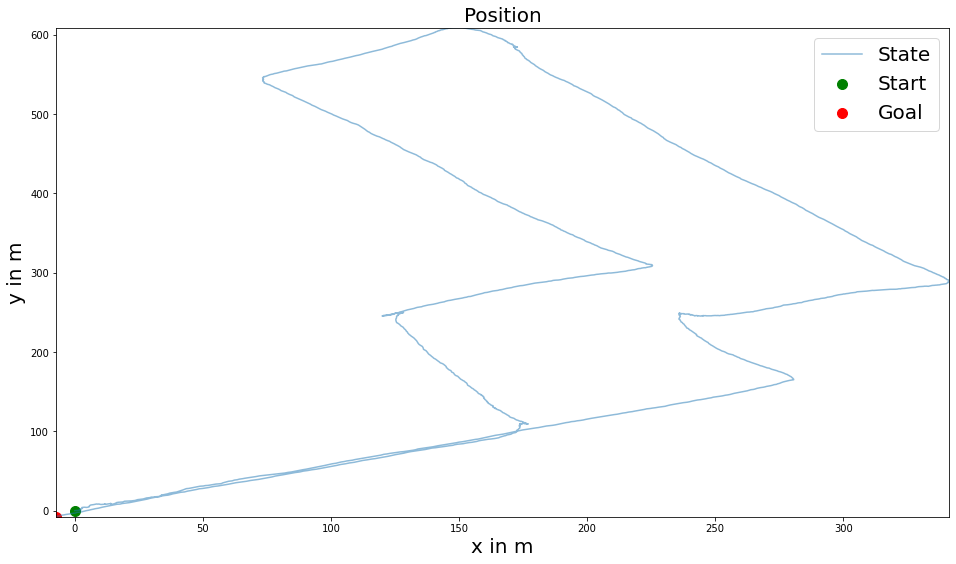

In [20]:
fig = plt.figure(figsize=(16, 9))

#plt.step(px, py, label="$GNSS$")

plt.scatter(xt[0], yt[0], s=100, label="Start", c="g")
plt.scatter(xt[-1], yt[-1], s=100, label="Goal", c="r")
plt.plot(xt, yt, label="State", alpha=0.5)
plt.xlabel("x in m", fontsize=20)
plt.ylabel("y in m", fontsize=20)
plt.title("Position", fontsize=20)
plt.legend(loc="best", fontsize=20)
plt.xlim(min(xt), max(xt))
plt.ylim(min(yt), max(yt))

## Conclusion

In [24]:
dist = np.cumsum(np.sqrt(np.diff(xt) ** 2 + np.diff(yt) ** 2))
print("You have drifted %d units from the origin." % dist[-1])

You have drifted 1862 units from the origin.


#### As you can see, bad idea just to measure the acceleration and try to get the position. The errors integrating up, so your position estimation is drifting.